In [69]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.utils.extmath import randomized_svd
from prettytable import PrettyTable
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from dotenv import dotenv_values 
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
import scipy.io
import pyvista as pv
import h5py
import mat73
from scipy import signal
import dask.array as da
from dask.distributed import Client, LocalCluster
import pandas as pd

config = dotenv_values("../.env")


In [70]:
# # Setup Dask client
# # cluster = LocalCluster() # Launches a scheduler and workers locally
# # client = Client(cluster) # Connect to distributed cluster and override default
client = Client('tcp://127.0.0.1:8786')
client.cluster

In [ ]:
####### # Set up hyperparameters ROMs  #######
n_timesteps = 1000 # Number of timesteps to pull from each episode
dt = 0.01
ns_ROM = np.arange(4,24,4) # Dimensions of ROM state space
ns_ROM_lopinf = np.array([2,4,6,8,10])*2 # Dimensions of ROM state space

# Training Trials 
train_trials = [16,35, 39] #[0,1,3,4,5,6,7,8,11,12,13,14,15,16,18,19,20,22,23,24,26,27,28,29,30,31,32,33,35,36,37,39]
n_train = len(train_trials) # Number of training trials

# Testing Trials
test_trials = [2,9,10,17,21,25,34,38]
n_test = len(test_trials) # Number of testing trials

# Combined list of trials
trials = train_trials + test_trials
totalTrials = 40

In [72]:
print(trials)

[16, 35, 39, 2, 9, 10, 17, 21, 25, 34, 38]


In [73]:
####### Set up filepaths #######
# Setup filepaths for reading data 
filepath = config["currentDirectory"] + "data/archivedDataSets/ContiguousAssembly/"
romDir = config["currentDirectory"] + "data/archivedDataSets/ContiguousAssembly/ROMs/"

In [74]:
# Read in all data 
data = h5py.File(filepath+ "FreqSweepDataset.hdf5", 'r')
X_fom = da.from_array(data["stateData"], chunks=(4096, 4096,1))
X_fom = X_fom[:,:,0:]
U_fom = da.from_array(data["inputData"], chunks=(4096, 4096,1))
U_fom = U_fom[:,:,0:]
Y_fom = da.from_array(data["outputData"], chunks=(4096, 4096,1))
Y_fom = Y_fom[:,:,0:]
x0 = data["stateData"][:,0,0]
y0 = data["outputData"][:,0,0]
n = X_fom.shape[0]
l = U_fom.shape[0]
m = Y_fom.shape[0]
# # Collect initial condition offsets for each episode and center each episode
X0 = da.zeros((n,totalTrials))
Y0 = da.zeros((m,totalTrials))
for i in range(totalTrials):
    X0[:,i] = X_fom[:,0,i]
    Y0[:,i] = Y_fom[:,0,i]
    # X_fom[:,:,i] = X_fom[:,:,i] - X0[:,i].reshape(-1,1)
    # Y_fom[:,:,i] = Y_fom[:,:,i] - Y0[:,i].reshape(-1,1)
print("Done loading in data.")


Done loading in data.


# Open Loop Estimation with Linear Models

In [75]:
# Initialize arrays to hold RMS and relative errors for each rom dimension for each episode for both outputs and for FOM states
error_output_era_rms = np.zeros((n_train+n_test,len(ns_ROM)))
error_output_era_rel = np.zeros((n_train+n_test,len(ns_ROM)))
# error_state_era_rms = np.zeros((n_train+n_test,len(ns_ROM)))
# error_state_era_rel = np.zeros((n_train+n_test,len(ns_ROM)))

error_output_dmdc_rms = np.zeros((n_train+n_test,len(ns_ROM)))
error_output_dmdc_rel = np.zeros((n_train+n_test,len(ns_ROM)))
error_state_dmdc_rms = np.zeros((n_train+n_test,len(ns_ROM)))
error_state_dmdc_rel = np.zeros((n_train+n_test,len(ns_ROM)))

error_output_lopinf_rms = np.zeros((n_train+n_test,len(ns_ROM_lopinf)))
error_output_lopinf_rel = np.zeros((n_train+n_test,len(ns_ROM_lopinf)))
error_state_lopinf_rms = np.zeros((n_train+n_test,len(ns_ROM_lopinf)))
error_state_lopinf_rel = np.zeros((n_train+n_test,len(ns_ROM_lopinf)))


In [76]:
# For each ROM dimension, simulate the roms behavior with the inputs from an episode and calculate the RMS and relative errors
for k in range(len(ns_ROM)):
    print("Starting with ROM dimension: " + str(ns_ROM[k]))
    n_ROM = ns_ROM[k]
    # Load in the ROM matrices
    era_mats = np.load(romDir + "eraSystemMatrices_" + str(ns_ROM[k]) + "dim_3train.npz")
    A_era = era_mats["A_era"]
    B_era = era_mats["B_era"]
    C_era = era_mats["C_era"]
    D_era = era_mats["D_era"]

    dmdc_mats = np.load(romDir + "dmdcSystemMatrices_" + str(ns_ROM[k]) + "dim_3train.npz")
    A_dmdc = dmdc_mats["A_dmdc"]
    B_dmdc = dmdc_mats["B_dmdc"]
    C_dmdc = dmdc_mats["C_dmdc"]
    basis_dmdc = dmdc_mats["basis_dmdc"]
    # Load in the LOpInf ROM matrices if the dimension is in ns_ROM_lopinf
    if n_ROM in ns_ROM_lopinf:
        lopinf_mats = np.load(romDir + "lopinfSystemMatrices_" + str(ns_ROM[k]) + "dim_1train.npz")
        A_lopinf = lopinf_mats["A_lopinf"]
        B_lopinf = lopinf_mats["B_lopinf"]
        C_lopinf = lopinf_mats["C_lopinf"]
        basis_lopinf = lopinf_mats["basis_lopinf"]    

    for j in range(n_train+n_test):
        print("Starting with episode: " + str(trials[j]))
        ## ERA
        # print("ERA")
        # Initialize state and output arrays for ERA
        X_era = np.zeros((n_ROM, n_timesteps))
        X_era[:, [0]] = np.zeros((n_ROM, 1))
        Y_era = np.zeros((m, n_timesteps))
        Y_era[:, [0]] = np.dot(C_era, X_era[:, [0]])
        u = U_fom[:,:,trials[j]].compute()
        # Simulate system
        for i in range(1, n_timesteps):
            # print("ERA: " + str(i) + " of " + str(n_timesteps))
            X_era[:, i] = np.dot(A_era, X_era[:, i-1]) + np.dot(B_era, u[:, i-1])
            Y_era[:, i] = np.dot(C_era, X_era[:, i]) + np.dot(D_era, u[:, i])
        # Add initial condition to output to get unshifted output
        Y_era = Y_era + Y0[:,trials[j]].compute().reshape(-1,1)
        # Compute RMS and relative errors
        Y_ep_full = Y_fom[:,:,trials[j]].compute()
        X_fom_ep_full = X_fom[:,:,trials[j]].compute()

        error_output_era_rms[j,k] = np.sqrt(np.mean((Y_ep_full - Y_era)**2))
        error_output_era_rel[j,k] = np.linalg.norm(Y_ep_full - Y_era)/np.linalg.norm(Y_ep_full)

        # Initialize state and output arrays for DMDc
        # print("DMDc")
        X_dmdc = np.zeros((n_ROM, n_timesteps))
        X_dmdc[:, [0]] = np.zeros((n_ROM, 1))
        Y_dmdc = np.zeros((m, n_timesteps))
        Y_dmdc[:, [0]] = np.dot(C_dmdc, X_dmdc[:, [0]])
        u = U_fom[:,:,trials[j]].compute()
        # Simulate system
        for i in range(1, n_timesteps):
            # print("DMDc: " + str(i) + " of " + str(n_timesteps))
            X_dmdc[:, i] = np.dot(A_dmdc, X_dmdc[:, i-1]) + np.dot(B_dmdc, u[:, i-1])
            Y_dmdc[:, i] = np.dot(C_dmdc, X_dmdc[:, i])
        # Project reduced order state back to full order state
        X_dmdc_full = np.dot(basis_dmdc, X_dmdc)
        # Add initial condition to output and state to get unshifted output and state
        Y_dmdc = Y_dmdc + Y0[:,trials[j]].compute().reshape(-1,1)
        X_dmdc_full = X_dmdc_full + X0[:,trials[j]].compute().reshape(-1,1)
        # Compute RMS and relative errors
        error_output_dmdc_rms[j,k] = np.sqrt(np.mean((Y_ep_full - Y_dmdc)**2))
        error_output_dmdc_rel[j,k] = np.linalg.norm(Y_ep_full - Y_dmdc)/np.linalg.norm(Y_ep_full)
        error_state_dmdc_rms[j,k] = np.sqrt(np.mean((X_fom_ep_full - X_dmdc_full)**2))
        error_state_dmdc_rel[j,k] = np.linalg.norm(X_fom_ep_full - X_dmdc_full)/np.linalg.norm(X_fom_ep_full)

        # Initialize state and output arrays for LOpInf
        if n_ROM in ns_ROM_lopinf:
            # print("LOpInf")
            X_lopinf = np.zeros((n_ROM, n_timesteps))
            X_lopinf[:, [0]] = np.zeros((n_ROM, 1))
            Y_lopinf = np.zeros((m, n_timesteps))
            Y_lopinf[:, [0]] = np.dot(C_lopinf, X_lopinf[:, [0]])
            u = U_fom[:,:,trials[j]].compute()
            # Simulate system
            for i in range(1, n_timesteps):
                # print("LOpInf: " + str(i) + " of " + str(n_timesteps))
                X_lopinf[:, i] = np.dot(A_lopinf, X_lopinf[:, i-1]) + np.dot(B_lopinf, u[:, i-1])
                Y_lopinf[:, i] = np.dot(C_lopinf, X_lopinf[:, i]) 
            # Project reduced order state back to full order state
            X_lopinf_full = np.dot(basis_lopinf, X_lopinf)
            # Add initial condition to output and state to get unshifted output and state
            Y_lopinf = Y_lopinf + Y0[:,trials[j]].compute().reshape(-1,1)
            X_lopinf_full = X_lopinf_full + X0[:,trials[j]].compute().reshape(-1,1)
            # Compute RMS and relative errors and place at the index where the dimension is in ns_ROM_lopinf
            error_output_lopinf_rms[j,np.where(ns_ROM_lopinf == n_ROM)[0][0]] = np.sqrt(np.mean((Y_ep_full - Y_lopinf)**2))
            error_output_lopinf_rel[j,np.where(ns_ROM_lopinf == n_ROM)[0][0]] = np.linalg.norm(Y_ep_full - Y_lopinf)/np.linalg.norm(Y_ep_full)
            error_state_lopinf_rms[j,np.where(ns_ROM_lopinf == n_ROM)[0][0]] = np.sqrt(np.mean((X_fom_ep_full - X_lopinf_full)**2))
            error_state_lopinf_rel[j,np.where(ns_ROM_lopinf == n_ROM)[0][0]] = np.linalg.norm(X_fom_ep_full - X_lopinf_full)/np.linalg.norm(X_fom_ep_full)
            


Starting with ROM dimension: 4
Starting with episode: 16
Starting with episode: 35
Starting with episode: 39
Starting with episode: 2
Starting with episode: 9
Starting with episode: 10
Starting with episode: 17
Starting with episode: 21
Starting with episode: 25
Starting with episode: 34
Starting with episode: 38
Starting with ROM dimension: 8
Starting with episode: 16
Starting with episode: 35
Starting with episode: 39
Starting with episode: 2
Starting with episode: 9
Starting with episode: 10
Starting with episode: 17
Starting with episode: 21
Starting with episode: 25
Starting with episode: 34
Starting with episode: 38
Starting with ROM dimension: 12
Starting with episode: 16
Starting with episode: 35
Starting with episode: 39
Starting with episode: 2
Starting with episode: 9
Starting with episode: 10
Starting with episode: 17
Starting with episode: 21
Starting with episode: 25
Starting with episode: 34
Starting with episode: 38
Starting with ROM dimension: 16
Starting with episode:

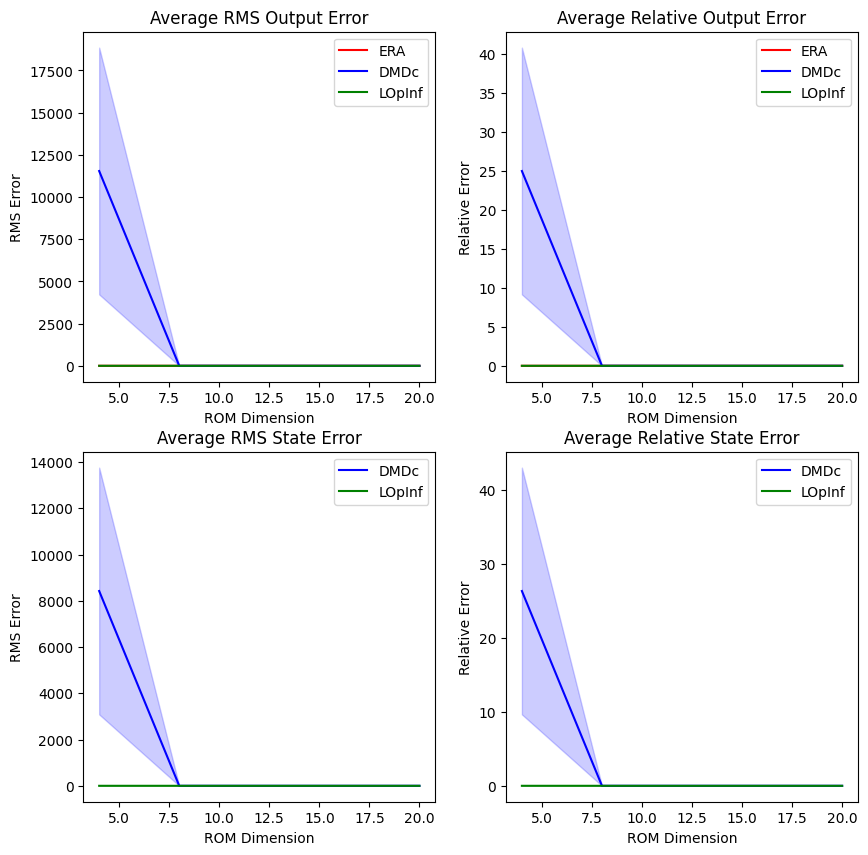

In [77]:
# Compute average errors for each ROM dimension over training episodes
avg_error_output_era_rms = np.mean(error_output_era_rms[0:n_train,:], axis=0)
avg_error_output_era_rel = np.mean(error_output_era_rel[0:n_train,:], axis=0)
avg_error_output_dmdc_rms = np.mean(error_output_dmdc_rms[0:n_train,:], axis=0)
avg_error_output_dmdc_rel = np.mean(error_output_dmdc_rel[0:n_train,:], axis=0)
avg_error_state_dmdc_rms = np.mean(error_state_dmdc_rms[0:n_train,:], axis=0)
avg_error_state_dmdc_rel = np.mean(error_state_dmdc_rel[0:n_train,:], axis=0)
avg_error_output_lopinf_rms = np.mean(error_output_lopinf_rms[0:n_train,:], axis=0)
avg_error_output_lopinf_rel = np.mean(error_output_lopinf_rel[0:n_train,:], axis=0)
avg_error_state_lopinf_rms = np.mean(error_state_lopinf_rms[0:n_train,:], axis=0)
avg_error_state_lopinf_rel = np.mean(error_state_lopinf_rel[0:n_train,:], axis=0)

# Compute standard deviation of errors for each ROM dimension over training episodes
std_error_output_era_rms = np.std(error_output_era_rms[0:n_train,:], axis=0)
std_error_output_era_rel = np.std(error_output_era_rel[0:n_train,:], axis=0)
std_error_output_dmdc_rms = np.std(error_output_dmdc_rms[0:n_train,:], axis=0)
std_error_output_dmdc_rel = np.std(error_output_dmdc_rel[0:n_train,:], axis=0)
std_error_state_dmdc_rms = np.std(error_state_dmdc_rms[0:n_train,:], axis=0)
std_error_state_dmdc_rel = np.std(error_state_dmdc_rel[0:n_train,:], axis=0)
std_error_output_lopinf_rms = np.std(error_output_lopinf_rms[0:n_train,:], axis=0)
std_error_output_lopinf_rel = np.std(error_output_lopinf_rel[0:n_train,:], axis=0)
std_error_state_lopinf_rms = np.std(error_state_lopinf_rms[0:n_train,:], axis=0)
std_error_state_lopinf_rel = np.std(error_state_lopinf_rel[0:n_train,:], axis=0)


# Plot the RMS and relative output errors on separate plots for each ROM dimension for training episodes with ERA in red, DMDc in blue, and LOpInf in green (plot standard deviation as shaded region around average error)
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,0].plot(ns_ROM, avg_error_output_era_rms, 'r', label='ERA')
ax[0,0].fill_between(ns_ROM, avg_error_output_era_rms - std_error_output_era_rms, avg_error_output_era_rms + std_error_output_era_rms, color='r', alpha=0.2)
ax[0,0].plot(ns_ROM, avg_error_output_dmdc_rms, 'b', label='DMDc')
ax[0,0].fill_between(ns_ROM, avg_error_output_dmdc_rms - std_error_output_dmdc_rms, avg_error_output_dmdc_rms + std_error_output_dmdc_rms, color='b', alpha=0.2)
ax[0,0].plot(ns_ROM_lopinf, avg_error_output_lopinf_rms, 'g', label='LOpInf')
ax[0,0].fill_between(ns_ROM_lopinf, avg_error_output_lopinf_rms - std_error_output_lopinf_rms, avg_error_output_lopinf_rms + std_error_output_lopinf_rms, color='g', alpha=0.2)
ax[0,0].set_title('Average RMS Output Error')
ax[0,0].set_xlabel('ROM Dimension')
ax[0,0].set_ylabel('RMS Error')
ax[0,0].legend()
ax[0,1].plot(ns_ROM, avg_error_output_era_rel, 'r', label='ERA')
ax[0,1].fill_between(ns_ROM, avg_error_output_era_rel - std_error_output_era_rel, avg_error_output_era_rel + std_error_output_era_rel, color='r', alpha=0.2)
ax[0,1].plot(ns_ROM, avg_error_output_dmdc_rel, 'b', label='DMDc')
ax[0,1].fill_between(ns_ROM, avg_error_output_dmdc_rel - std_error_output_dmdc_rel, avg_error_output_dmdc_rel + std_error_output_dmdc_rel, color='b', alpha=0.2)
ax[0,1].plot(ns_ROM_lopinf, avg_error_output_lopinf_rel, 'g', label='LOpInf')
ax[0,1].fill_between(ns_ROM_lopinf, avg_error_output_lopinf_rel - std_error_output_lopinf_rel, avg_error_output_lopinf_rel + std_error_output_lopinf_rel, color='g', alpha=0.2)
ax[0,1].set_title('Average Relative Output Error')
ax[0,1].set_xlabel('ROM Dimension')
ax[0,1].set_ylabel('Relative Error')
ax[0,1].legend()
ax[1,0].plot(ns_ROM, avg_error_state_dmdc_rms, 'b', label='DMDc')
ax[1,0].fill_between(ns_ROM, avg_error_state_dmdc_rms - std_error_state_dmdc_rms, avg_error_state_dmdc_rms + std_error_state_dmdc_rms, color='b', alpha=0.2)
ax[1,0].plot(ns_ROM_lopinf, avg_error_state_lopinf_rms, 'g', label='LOpInf')
ax[1,0].fill_between(ns_ROM_lopinf, avg_error_state_lopinf_rms - std_error_state_lopinf_rms, avg_error_state_lopinf_rms + std_error_state_lopinf_rms, color='g', alpha=0.2)
ax[1,0].set_title('Average RMS State Error')
ax[1,0].set_xlabel('ROM Dimension')
ax[1,0].set_ylabel('RMS Error')
ax[1,0].legend()
ax[1,1].plot(ns_ROM, avg_error_state_dmdc_rel, 'b', label='DMDc')
ax[1,1].fill_between(ns_ROM, avg_error_state_dmdc_rel - std_error_state_dmdc_rel, avg_error_state_dmdc_rel + std_error_state_dmdc_rel, color='b', alpha=0.2)
ax[1,1].plot(ns_ROM_lopinf, avg_error_state_lopinf_rel, 'g', label='LOpInf')
ax[1,1].fill_between(ns_ROM_lopinf, avg_error_state_lopinf_rel - std_error_state_lopinf_rel, avg_error_state_lopinf_rel + std_error_state_lopinf_rel, color='g', alpha=0.2)
ax[1,1].set_title('Average Relative State Error')
ax[1,1].set_xlabel('ROM Dimension')
ax[1,1].set_ylabel('Relative Error')
ax[1,1].legend()
plt.show()


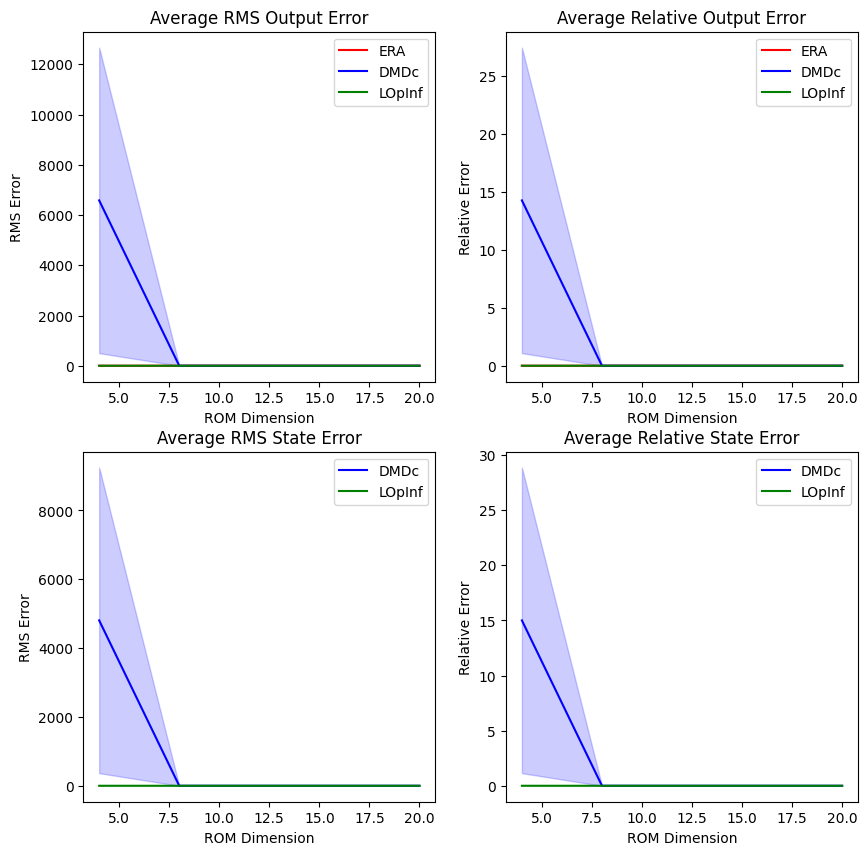

In [78]:
# Compute average errors for each ROM dimension over testing episodes
avg_error_output_era_rms = np.mean(error_output_era_rms[n_train:,:], axis=0)
avg_error_output_era_rel = np.mean(error_output_era_rel[n_train:,:], axis=0)
avg_error_output_dmdc_rms = np.mean(error_output_dmdc_rms[n_train:,:], axis=0)
avg_error_output_dmdc_rel = np.mean(error_output_dmdc_rel[n_train:,:], axis=0)
avg_error_state_dmdc_rms = np.mean(error_state_dmdc_rms[n_train:,:], axis=0)
avg_error_state_dmdc_rel = np.mean(error_state_dmdc_rel[n_train:,:], axis=0)
avg_error_output_lopinf_rms = np.mean(error_output_lopinf_rms[n_train:,:], axis=0)
avg_error_output_lopinf_rel = np.mean(error_output_lopinf_rel[n_train:,:], axis=0)
avg_error_state_lopinf_rms = np.mean(error_state_lopinf_rms[n_train:,:], axis=0)
avg_error_state_lopinf_rel = np.mean(error_state_lopinf_rel[n_train:,:], axis=0)

# Compute standard deviation of errors for each ROM dimension over testing episodes
std_error_output_era_rms = np.std(error_output_era_rms[n_train:,:], axis=0)
std_error_output_era_rel = np.std(error_output_era_rel[n_train:,:], axis=0)
std_error_output_dmdc_rms = np.std(error_output_dmdc_rms[n_train:,:], axis=0)
std_error_output_dmdc_rel = np.std(error_output_dmdc_rel[n_train:,:], axis=0)
std_error_state_dmdc_rms = np.std(error_state_dmdc_rms[n_train:,:], axis=0)
std_error_state_dmdc_rel = np.std(error_state_dmdc_rel[n_train:,:], axis=0)
std_error_output_lopinf_rms = np.std(error_output_lopinf_rms[n_train:,:], axis=0)
std_error_output_lopinf_rel = np.std(error_output_lopinf_rel[n_train:,:], axis=0)
std_error_state_lopinf_rms = np.std(error_state_lopinf_rms[n_train:,:], axis=0)
std_error_state_lopinf_rel = np.std(error_state_lopinf_rel[n_train:,:], axis=0)

# Plot the RMS and relative output errors on separate plots for each ROM dimension for testing episodes with ERA in red and DMDc in blue and LOpInf in green (plot standard deviation as shaded region around average error)
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,0].plot(ns_ROM, avg_error_output_era_rms, 'r', label='ERA')
ax[0,0].fill_between(ns_ROM, avg_error_output_era_rms - std_error_output_era_rms, avg_error_output_era_rms + std_error_output_era_rms, color='r', alpha=0.2)
ax[0,0].plot(ns_ROM, avg_error_output_dmdc_rms, 'b', label='DMDc')
ax[0,0].fill_between(ns_ROM, avg_error_output_dmdc_rms - std_error_output_dmdc_rms, avg_error_output_dmdc_rms + std_error_output_dmdc_rms, color='b', alpha=0.2)
ax[0,0].plot(ns_ROM_lopinf, avg_error_output_lopinf_rms, 'g', label='LOpInf')
ax[0,0].fill_between(ns_ROM_lopinf, avg_error_output_lopinf_rms - std_error_output_lopinf_rms, avg_error_output_lopinf_rms + std_error_output_lopinf_rms, color='g', alpha=0.2)
ax[0,0].set_title('Average RMS Output Error')
ax[0,0].set_xlabel('ROM Dimension')
ax[0,0].set_ylabel('RMS Error')
ax[0,0].legend()
ax[0,1].plot(ns_ROM, avg_error_output_era_rel, 'r', label='ERA')
ax[0,1].fill_between(ns_ROM, avg_error_output_era_rel - std_error_output_era_rel, avg_error_output_era_rel + std_error_output_era_rel, color='r', alpha=0.2)
ax[0,1].plot(ns_ROM, avg_error_output_dmdc_rel, 'b', label='DMDc')
ax[0,1].fill_between(ns_ROM, avg_error_output_dmdc_rel - std_error_output_dmdc_rel, avg_error_output_dmdc_rel + std_error_output_dmdc_rel, color='b', alpha=0.2)
ax[0,1].plot(ns_ROM_lopinf, avg_error_output_lopinf_rel, 'g', label='LOpInf')
ax[0,1].fill_between(ns_ROM_lopinf, avg_error_output_lopinf_rel - std_error_output_lopinf_rel, avg_error_output_lopinf_rel + std_error_output_lopinf_rel, color='g', alpha=0.2)
ax[0,1].set_title('Average Relative Output Error')
ax[0,1].set_xlabel('ROM Dimension')
ax[0,1].set_ylabel('Relative Error')
ax[0,1].legend()
ax[1,0].plot(ns_ROM, avg_error_state_dmdc_rms, 'b', label='DMDc')
ax[1,0].fill_between(ns_ROM, avg_error_state_dmdc_rms - std_error_state_dmdc_rms, avg_error_state_dmdc_rms + std_error_state_dmdc_rms, color='b', alpha=0.2)
ax[1,0].plot(ns_ROM_lopinf, avg_error_state_lopinf_rms, 'g', label='LOpInf')
ax[1,0].fill_between(ns_ROM_lopinf, avg_error_state_lopinf_rms - std_error_state_lopinf_rms, avg_error_state_lopinf_rms + std_error_state_lopinf_rms, color='g', alpha=0.2)
ax[1,0].set_title('Average RMS State Error')
ax[1,0].set_xlabel('ROM Dimension')
ax[1,0].set_ylabel('RMS Error')
ax[1,0].legend()
ax[1,1].plot(ns_ROM, avg_error_state_dmdc_rel, 'b', label='DMDc')
ax[1,1].fill_between(ns_ROM, avg_error_state_dmdc_rel - std_error_state_dmdc_rel, avg_error_state_dmdc_rel + std_error_state_dmdc_rel, color='b', alpha=0.2)
ax[1,1].plot(ns_ROM_lopinf, avg_error_state_lopinf_rel, 'g', label='LOpInf')
ax[1,1].fill_between(ns_ROM_lopinf, avg_error_state_lopinf_rel - std_error_state_lopinf_rel, avg_error_state_lopinf_rel + std_error_state_lopinf_rel, color='g', alpha=0.2)
ax[1,1].set_title('Average Relative State Error')
ax[1,1].set_xlabel('ROM Dimension')
ax[1,1].set_ylabel('Relative Error')
ax[1,1].legend()
plt.show()

In [79]:
# Save all errors for each trial, ROM type, and ROM size to a .npz file
errorFilepath = config["currentDirectory"] + "data/archivedDataSets/ContiguousAssembly/predictionErrors/"
np.savez(errorFilepath+"openLoopPredictionErrors.npz", error_output_era_rms=error_output_era_rms, error_output_era_rel=error_output_era_rel, error_output_dmdc_rms=error_output_dmdc_rms, error_output_dmdc_rel=error_output_dmdc_rel, error_state_dmdc_rms=error_state_dmdc_rms, error_state_dmdc_rel=error_state_dmdc_rel, error_output_lopinf_rms=error_output_lopinf_rms, error_output_lopinf_rel=error_output_lopinf_rel, error_state_lopinf_rms=error_state_lopinf_rms, error_state_lopinf_rel=error_state_lopinf_rel)

# Closed Loop Estimation with Linear State Estimator

In [80]:
####### # Set up hyperparameters ROMs  #######
n_timesteps = 1000 # Number of timesteps to pull from each episode
dt = 0.01
ns_ROM = np.arange(4,24,4) # Dimensions of ROM state space
ns_ROM_lopinf = np.array([2,4,6,8,10])*2 # Dimensions of ROM state space

# Training Trials 
train_trials = [16,35, 39] #[0,1,3,4,5,6,7,8,11,12,13,14,15,16,18,19,20,22,23,24,26,27,28,29,30,31,32,33,35,36,37,39]
n_train = len(train_trials) # Number of training trials

# Testing Trials
test_trials = [2,9,10,17,21,25,34,38]
n_test = len(test_trials) # Number of testing trials


# Combined list of trials
trials = train_trials + test_trials
totalTrials = 40

In [81]:
####### Set up filepaths #######
# Setup filepaths for reading data 
filepath = config["currentDirectory"] + "data/archivedDataSets/ContiguousAssembly/"
romDir = config["currentDirectory"] + "data/archivedDataSets/ContiguousAssembly/ROMsWithObserverGains/"

In [82]:
# Read in all data 
data = h5py.File(filepath+ "FreqSweepDataset.hdf5", 'r')
X_fom = da.from_array(data["stateData"], chunks=(4096, 4096,1))
X_fom = X_fom[:,:,0:]
U_fom = da.from_array(data["inputData"], chunks=(4096, 4096,1))
U_fom = U_fom[:,:,0:]
Y_fom = da.from_array(data["outputData"], chunks=(4096, 4096,1))
Y_fom = Y_fom[:,:,0:]
x0 = data["stateData"][:,0,0]
y0 = data["outputData"][:,0,0]
n = X_fom.shape[0]
l = U_fom.shape[0]
m = Y_fom.shape[0]
# # Collect initial condition offsets for each episode and center each episode
X0 = da.zeros((n,totalTrials))
Y0 = da.zeros((m,totalTrials))
for i in range(totalTrials):
    X0[:,i] = X_fom[:,0,i]
    Y0[:,i] = Y_fom[:,0,i]
    # X_fom[:,:,i] = X_fom[:,:,i] - X0[:,i].reshape(-1,1)
    # Y_fom[:,:,i] = Y_fom[:,:,i] - Y0[:,i].reshape(-1,1)
print("Done loading in data.")


Done loading in data.


In [83]:
# Initialize arrays to hold RMS and relative errors for each rom dimension for each episode for both outputs and for FOM states
error_output_era_rms = np.zeros((n_train+n_test,len(ns_ROM)))
error_output_era_rel = np.zeros((n_train+n_test,len(ns_ROM)))
# error_state_era_rms = np.zeros((n_train+n_test,len(ns_ROM)))
# error_state_era_rel = np.zeros((n_train+n_test,len(ns_ROM)))

error_output_dmdc_rms = np.zeros((n_train+n_test,len(ns_ROM)))
error_output_dmdc_rel = np.zeros((n_train+n_test,len(ns_ROM)))
error_state_dmdc_rms = np.zeros((n_train+n_test,len(ns_ROM)))
error_state_dmdc_rel = np.zeros((n_train+n_test,len(ns_ROM)))

error_output_lopinf_rms = np.zeros((n_train+n_test,len(ns_ROM_lopinf)))
error_output_lopinf_rel = np.zeros((n_train+n_test,len(ns_ROM_lopinf)))
error_state_lopinf_rms = np.zeros((n_train+n_test,len(ns_ROM_lopinf)))
error_state_lopinf_rel = np.zeros((n_train+n_test,len(ns_ROM_lopinf)))


In [84]:
# For each ROM dimension, simulate the roms behavior with the inputs from an episode and calculate the RMS and relative errors
for k in range(len(ns_ROM)):
    print("Starting with ROM dimension: " + str(ns_ROM[k]))
    n_ROM = ns_ROM[k]
    # Load in the ROM matrices
    era_mats = scipy.io.loadmat(romDir + "eraSystemMatricesAndGains_" + str(ns_ROM[k]) + "dim_3train.mat")
    A_era = era_mats["A_era"]
    B_era = era_mats["B_era"]
    C_era = era_mats["C_era"]
    D_era = era_mats["D_era"]
    L_era = era_mats["L_era"]
    

    dmdc_mats = scipy.io.loadmat(romDir + "dmdcSystemMatricesAndGains_" + str(ns_ROM[k]) + "dim_3train.mat")
    A_dmdc = dmdc_mats["A_dmdc"]
    B_dmdc = dmdc_mats["B_dmdc"]
    C_dmdc = dmdc_mats["C_dmdc"]
    L_dmdc = dmdc_mats["L_dmdc"]
    basis_dmdc = dmdc_mats["basis_dmdc"]

    lopinf_mats = scipy.io.loadmat(romDir + "lopinfSystemMatricesAndGains_" + str(ns_ROM[k]) + "dim_1train.mat")
    A_lopinf = lopinf_mats["A_lopinf"]
    B_lopinf = lopinf_mats["B_lopinf"]
    C_lopinf = lopinf_mats["C_lopinf"]
    L_lopinf = lopinf_mats["L_lopinf"]
    basis_lopinf = lopinf_mats["basis_lopinf"]    

    for j in range(n_train+n_test):
        print("Starting with episode: " + str(trials[j]))
        ## ERA
        # print("ERA")
        # Initialize state and output arrays for ERA
        X_era = np.zeros((n_ROM, n_timesteps))
        X_era[:, [0]] = np.zeros((n_ROM, 1))
        Y_era = np.zeros((m, n_timesteps))
        Y_era[:, [0]] = np.dot(C_era, X_era[:, [0]])
        u = U_fom[:,:,trials[j]].compute()
        y = Y_fom[:,:,trials[j]] - Y0[:,trials[j]].reshape(-1,1)
        y = y.compute()
        # Simulate system with output feedback into observer
        for i in range(1, n_timesteps):
            # print("ERA: " + str(i) + " of " + str(n_timesteps))
            X_era[:, i] = np.dot(A_era, X_era[:, i-1]) + np.dot(B_era, u[:, i-1]) - L_era @ (Y_era[:, i-1] - y[:,i-1])
            Y_era[:, i] = np.dot(C_era, X_era[:, i]) + np.dot(D_era, u[:, i])
        # Add initial condition to output to get unshifted output
        Y_era = Y_era + Y0[:,trials[j]].compute().reshape(-1,1)
        # Compute RMS and relative errors
        Y_ep_full = Y_fom[:,:,trials[j]].compute()
        X_fom_ep_full = X_fom[:,:,trials[j]].compute()

        error_output_era_rms[j,k] = np.sqrt(np.mean((Y_ep_full - Y_era)**2))
        error_output_era_rel[j,k] = np.linalg.norm(Y_ep_full - Y_era)/np.linalg.norm(Y_ep_full)

        # Initialize state and output arrays for DMDc
        # print("DMDc")
        X_dmdc = np.zeros((n_ROM, n_timesteps))
        X_dmdc[:, [0]] = np.zeros((n_ROM, 1))
        Y_dmdc = np.zeros((m, n_timesteps))
        Y_dmdc[:, [0]] = np.dot(C_dmdc, X_dmdc[:, [0]])
        u = U_fom[:,:,trials[j]].compute()
        # Simulate system
        for i in range(1, n_timesteps):
            # print("DMDc: " + str(i) + " of " + str(n_timesteps))
            X_dmdc[:, i] = np.dot(A_dmdc, X_dmdc[:, i-1]) + np.dot(B_dmdc, u[:, i-1]) - L_dmdc @ (Y_dmdc[:, i-1] - y[:,i-1])
            Y_dmdc[:, i] = np.dot(C_dmdc, X_dmdc[:, i])
        # Project reduced order state back to full order state
        X_dmdc_full = np.dot(basis_dmdc, X_dmdc)
        # Add initial condition to output and state to get unshifted output and state
        Y_dmdc = Y_dmdc + Y0[:,trials[j]].compute().reshape(-1,1)
        X_dmdc_full = X_dmdc_full + X0[:,trials[j]].compute().reshape(-1,1)
        # Compute RMS and relative errors
        error_output_dmdc_rms[j,k] = np.sqrt(np.mean((Y_ep_full - Y_dmdc)**2))
        error_output_dmdc_rel[j,k] = np.linalg.norm(Y_ep_full - Y_dmdc)/np.linalg.norm(Y_ep_full)
        error_state_dmdc_rms[j,k] = np.sqrt(np.mean((X_fom_ep_full - X_dmdc_full)**2))
        error_state_dmdc_rel[j,k] = np.linalg.norm(X_fom_ep_full - X_dmdc_full)/np.linalg.norm(X_fom_ep_full)

        # Initialize state and output arrays for LOpInf
        if n_ROM in ns_ROM_lopinf:
            # print("LOpInf")
            X_lopinf = np.zeros((n_ROM, n_timesteps))
            X_lopinf[:, [0]] = np.zeros((n_ROM, 1))
            Y_lopinf = np.zeros((m, n_timesteps))
            Y_lopinf[:, [0]] = np.dot(C_lopinf, X_lopinf[:, [0]])
            u = U_fom[:,:,trials[j]].compute()
            # Simulate system
            for i in range(1, n_timesteps):
                # print("LOpInf: " + str(i) + " of " + str(n_timesteps))
                X_lopinf[:, i] = np.dot(A_lopinf, X_lopinf[:, i-1]) + np.dot(B_lopinf, u[:, i-1]) - L_lopinf @ (Y_lopinf[:, i-1] - y[:,i-1])
                Y_lopinf[:, i] = np.dot(C_lopinf, X_lopinf[:, i]) 
            # Project reduced order state back to full order state
            X_lopinf_full = np.dot(basis_lopinf, X_lopinf)
            # Add initial condition to output and state to get unshifted output and state
            Y_lopinf = Y_lopinf + Y0[:,trials[j]].compute().reshape(-1,1)
            X_lopinf_full = X_lopinf_full + X0[:,trials[j]].compute().reshape(-1,1)
            # Compute RMS and relative errors and place at the index where the dimension is in ns_ROM_lopinf
            error_output_lopinf_rms[j,np.where(ns_ROM_lopinf == n_ROM)[0][0]] = np.sqrt(np.mean((Y_ep_full - Y_lopinf)**2))
            error_output_lopinf_rel[j,np.where(ns_ROM_lopinf == n_ROM)[0][0]] = np.linalg.norm(Y_ep_full - Y_lopinf)/np.linalg.norm(Y_ep_full)
            error_state_lopinf_rms[j,np.where(ns_ROM_lopinf == n_ROM)[0][0]] = np.sqrt(np.mean((X_fom_ep_full - X_lopinf_full)**2))
            error_state_lopinf_rel[j,np.where(ns_ROM_lopinf == n_ROM)[0][0]] = np.linalg.norm(X_fom_ep_full - X_lopinf_full)/np.linalg.norm(X_fom_ep_full)
            


Starting with ROM dimension: 4
Starting with episode: 16
Starting with episode: 35
Starting with episode: 39
Starting with episode: 2
Starting with episode: 9
Starting with episode: 10
Starting with episode: 17
Starting with episode: 21
Starting with episode: 25
Starting with episode: 34
Starting with episode: 38
Starting with ROM dimension: 8
Starting with episode: 16
Starting with episode: 35
Starting with episode: 39
Starting with episode: 2
Starting with episode: 9
Starting with episode: 10
Starting with episode: 17
Starting with episode: 21
Starting with episode: 25
Starting with episode: 34
Starting with episode: 38
Starting with ROM dimension: 12
Starting with episode: 16
Starting with episode: 35
Starting with episode: 39
Starting with episode: 2
Starting with episode: 9
Starting with episode: 10
Starting with episode: 17
Starting with episode: 21
Starting with episode: 25
Starting with episode: 34
Starting with episode: 38
Starting with ROM dimension: 16
Starting with episode:

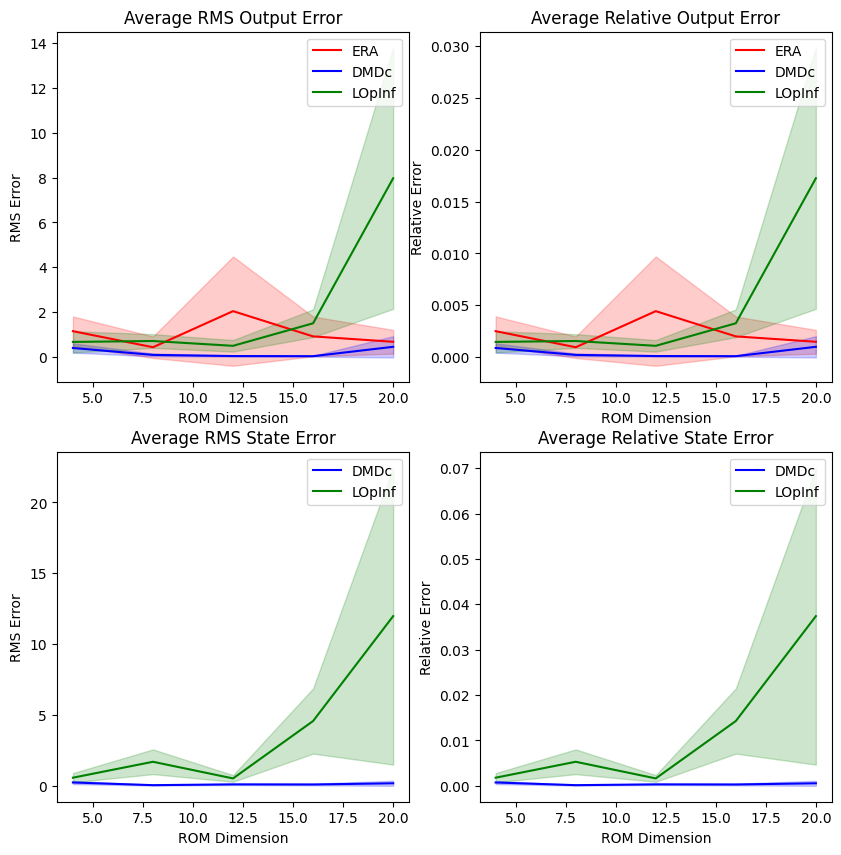

In [85]:
# Compute average errors for each ROM dimension over training episodes
avg_error_output_era_rms = np.mean(error_output_era_rms[0:n_train,:], axis=0)
avg_error_output_era_rel = np.mean(error_output_era_rel[0:n_train,:], axis=0)
avg_error_output_dmdc_rms = np.mean(error_output_dmdc_rms[0:n_train,:], axis=0)
avg_error_output_dmdc_rel = np.mean(error_output_dmdc_rel[0:n_train,:], axis=0)
avg_error_state_dmdc_rms = np.mean(error_state_dmdc_rms[0:n_train,:], axis=0)
avg_error_state_dmdc_rel = np.mean(error_state_dmdc_rel[0:n_train,:], axis=0)
avg_error_output_lopinf_rms = np.mean(error_output_lopinf_rms[0:n_train,:], axis=0)
avg_error_output_lopinf_rel = np.mean(error_output_lopinf_rel[0:n_train,:], axis=0)
avg_error_state_lopinf_rms = np.mean(error_state_lopinf_rms[0:n_train,:], axis=0)
avg_error_state_lopinf_rel = np.mean(error_state_lopinf_rel[0:n_train,:], axis=0)

# Compute standard deviation of errors for each ROM dimension over training episodes
std_error_output_era_rms = np.std(error_output_era_rms[0:n_train,:], axis=0)
std_error_output_era_rel = np.std(error_output_era_rel[0:n_train,:], axis=0)
std_error_output_dmdc_rms = np.std(error_output_dmdc_rms[0:n_train,:], axis=0)
std_error_output_dmdc_rel = np.std(error_output_dmdc_rel[0:n_train,:], axis=0)
std_error_state_dmdc_rms = np.std(error_state_dmdc_rms[0:n_train,:], axis=0)
std_error_state_dmdc_rel = np.std(error_state_dmdc_rel[0:n_train,:], axis=0)
std_error_output_lopinf_rms = np.std(error_output_lopinf_rms[0:n_train,:], axis=0)
std_error_output_lopinf_rel = np.std(error_output_lopinf_rel[0:n_train,:], axis=0)
std_error_state_lopinf_rms = np.std(error_state_lopinf_rms[0:n_train,:], axis=0)
std_error_state_lopinf_rel = np.std(error_state_lopinf_rel[0:n_train,:], axis=0)


# Plot the RMS and relative output errors on separate plots for each ROM dimension for training episodes with ERA in red, DMDc in blue, and LOpInf in green (plot standard deviation as shaded region around average error)
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,0].plot(ns_ROM, avg_error_output_era_rms, 'r', label='ERA')
ax[0,0].fill_between(ns_ROM, avg_error_output_era_rms - std_error_output_era_rms, avg_error_output_era_rms + std_error_output_era_rms, color='r', alpha=0.2)
ax[0,0].plot(ns_ROM, avg_error_output_dmdc_rms, 'b', label='DMDc')
ax[0,0].fill_between(ns_ROM, avg_error_output_dmdc_rms - std_error_output_dmdc_rms, avg_error_output_dmdc_rms + std_error_output_dmdc_rms, color='b', alpha=0.2)
ax[0,0].plot(ns_ROM_lopinf, avg_error_output_lopinf_rms, 'g', label='LOpInf')
ax[0,0].fill_between(ns_ROM_lopinf, avg_error_output_lopinf_rms - std_error_output_lopinf_rms, avg_error_output_lopinf_rms + std_error_output_lopinf_rms, color='g', alpha=0.2)
ax[0,0].set_title('Average RMS Output Error')
ax[0,0].set_xlabel('ROM Dimension')
ax[0,0].set_ylabel('RMS Error')
ax[0,0].legend()
ax[0,1].plot(ns_ROM, avg_error_output_era_rel, 'r', label='ERA')
ax[0,1].fill_between(ns_ROM, avg_error_output_era_rel - std_error_output_era_rel, avg_error_output_era_rel + std_error_output_era_rel, color='r', alpha=0.2)
ax[0,1].plot(ns_ROM, avg_error_output_dmdc_rel, 'b', label='DMDc')
ax[0,1].fill_between(ns_ROM, avg_error_output_dmdc_rel - std_error_output_dmdc_rel, avg_error_output_dmdc_rel + std_error_output_dmdc_rel, color='b', alpha=0.2)
ax[0,1].plot(ns_ROM_lopinf, avg_error_output_lopinf_rel, 'g', label='LOpInf')
ax[0,1].fill_between(ns_ROM_lopinf, avg_error_output_lopinf_rel - std_error_output_lopinf_rel, avg_error_output_lopinf_rel + std_error_output_lopinf_rel, color='g', alpha=0.2)
ax[0,1].set_title('Average Relative Output Error')
ax[0,1].set_xlabel('ROM Dimension')
ax[0,1].set_ylabel('Relative Error')
ax[0,1].legend()
ax[1,0].plot(ns_ROM, avg_error_state_dmdc_rms, 'b', label='DMDc')
ax[1,0].fill_between(ns_ROM, avg_error_state_dmdc_rms - std_error_state_dmdc_rms, avg_error_state_dmdc_rms + std_error_state_dmdc_rms, color='b', alpha=0.2)
ax[1,0].plot(ns_ROM_lopinf, avg_error_state_lopinf_rms, 'g', label='LOpInf')
ax[1,0].fill_between(ns_ROM_lopinf, avg_error_state_lopinf_rms - std_error_state_lopinf_rms, avg_error_state_lopinf_rms + std_error_state_lopinf_rms, color='g', alpha=0.2)
ax[1,0].set_title('Average RMS State Error')
ax[1,0].set_xlabel('ROM Dimension')
ax[1,0].set_ylabel('RMS Error')
ax[1,0].legend()
ax[1,1].plot(ns_ROM, avg_error_state_dmdc_rel, 'b', label='DMDc')
ax[1,1].fill_between(ns_ROM, avg_error_state_dmdc_rel - std_error_state_dmdc_rel, avg_error_state_dmdc_rel + std_error_state_dmdc_rel, color='b', alpha=0.2)
ax[1,1].plot(ns_ROM_lopinf, avg_error_state_lopinf_rel, 'g', label='LOpInf')
ax[1,1].fill_between(ns_ROM_lopinf, avg_error_state_lopinf_rel - std_error_state_lopinf_rel, avg_error_state_lopinf_rel + std_error_state_lopinf_rel, color='g', alpha=0.2)
ax[1,1].set_title('Average Relative State Error')
ax[1,1].set_xlabel('ROM Dimension')
ax[1,1].set_ylabel('Relative Error')
ax[1,1].legend()
plt.show()


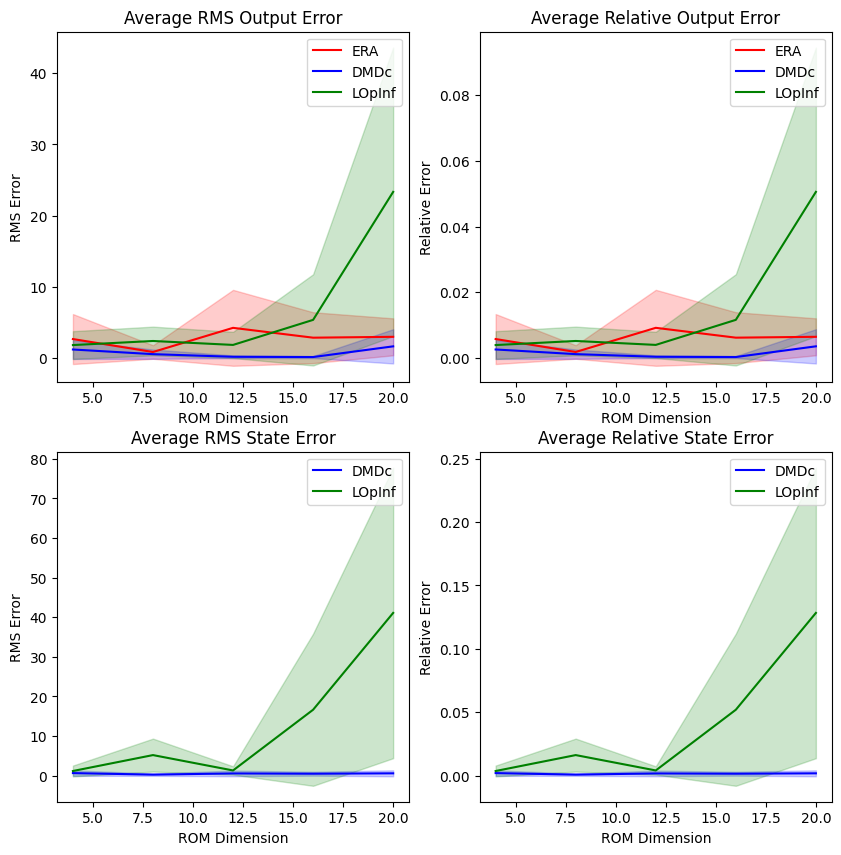

In [86]:
# Compute average errors for each ROM dimension over testing episodes
avg_error_output_era_rms = np.mean(error_output_era_rms[n_train:,:], axis=0)
avg_error_output_era_rel = np.mean(error_output_era_rel[n_train:,:], axis=0)
avg_error_output_dmdc_rms = np.mean(error_output_dmdc_rms[n_train:,:], axis=0)
avg_error_output_dmdc_rel = np.mean(error_output_dmdc_rel[n_train:,:], axis=0)
avg_error_state_dmdc_rms = np.mean(error_state_dmdc_rms[n_train:,:], axis=0)
avg_error_state_dmdc_rel = np.mean(error_state_dmdc_rel[n_train:,:], axis=0)
avg_error_output_lopinf_rms = np.mean(error_output_lopinf_rms[n_train:,:], axis=0)
avg_error_output_lopinf_rel = np.mean(error_output_lopinf_rel[n_train:,:], axis=0)
avg_error_state_lopinf_rms = np.mean(error_state_lopinf_rms[n_train:,:], axis=0)
avg_error_state_lopinf_rel = np.mean(error_state_lopinf_rel[n_train:,:], axis=0)

# Compute standard deviation of errors for each ROM dimension over testing episodes
std_error_output_era_rms = np.std(error_output_era_rms[n_train:,:], axis=0)
std_error_output_era_rel = np.std(error_output_era_rel[n_train:,:], axis=0)
std_error_output_dmdc_rms = np.std(error_output_dmdc_rms[n_train:,:], axis=0)
std_error_output_dmdc_rel = np.std(error_output_dmdc_rel[n_train:,:], axis=0)
std_error_state_dmdc_rms = np.std(error_state_dmdc_rms[n_train:,:], axis=0)
std_error_state_dmdc_rel = np.std(error_state_dmdc_rel[n_train:,:], axis=0)
std_error_output_lopinf_rms = np.std(error_output_lopinf_rms[n_train:,:], axis=0)
std_error_output_lopinf_rel = np.std(error_output_lopinf_rel[n_train:,:], axis=0)
std_error_state_lopinf_rms = np.std(error_state_lopinf_rms[n_train:,:], axis=0)
std_error_state_lopinf_rel = np.std(error_state_lopinf_rel[n_train:,:], axis=0)

# Plot the RMS and relative output errors on separate plots for each ROM dimension for testing episodes with ERA in red and DMDc in blue and LOpInf in green (plot standard deviation as shaded region around average error)
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,0].plot(ns_ROM, avg_error_output_era_rms, 'r', label='ERA')
ax[0,0].fill_between(ns_ROM, avg_error_output_era_rms - std_error_output_era_rms, avg_error_output_era_rms + std_error_output_era_rms, color='r', alpha=0.2)
ax[0,0].plot(ns_ROM, avg_error_output_dmdc_rms, 'b', label='DMDc')
ax[0,0].fill_between(ns_ROM, avg_error_output_dmdc_rms - std_error_output_dmdc_rms, avg_error_output_dmdc_rms + std_error_output_dmdc_rms, color='b', alpha=0.2)
ax[0,0].plot(ns_ROM_lopinf, avg_error_output_lopinf_rms, 'g', label='LOpInf')
ax[0,0].fill_between(ns_ROM_lopinf, avg_error_output_lopinf_rms - std_error_output_lopinf_rms, avg_error_output_lopinf_rms + std_error_output_lopinf_rms, color='g', alpha=0.2)
ax[0,0].set_title('Average RMS Output Error')
ax[0,0].set_xlabel('ROM Dimension')
ax[0,0].set_ylabel('RMS Error')
ax[0,0].legend()
ax[0,1].plot(ns_ROM, avg_error_output_era_rel, 'r', label='ERA')
ax[0,1].fill_between(ns_ROM, avg_error_output_era_rel - std_error_output_era_rel, avg_error_output_era_rel + std_error_output_era_rel, color='r', alpha=0.2)
ax[0,1].plot(ns_ROM, avg_error_output_dmdc_rel, 'b', label='DMDc')
ax[0,1].fill_between(ns_ROM, avg_error_output_dmdc_rel - std_error_output_dmdc_rel, avg_error_output_dmdc_rel + std_error_output_dmdc_rel, color='b', alpha=0.2)
ax[0,1].plot(ns_ROM_lopinf, avg_error_output_lopinf_rel, 'g', label='LOpInf')
ax[0,1].fill_between(ns_ROM_lopinf, avg_error_output_lopinf_rel - std_error_output_lopinf_rel, avg_error_output_lopinf_rel + std_error_output_lopinf_rel, color='g', alpha=0.2)
ax[0,1].set_title('Average Relative Output Error')
ax[0,1].set_xlabel('ROM Dimension')
ax[0,1].set_ylabel('Relative Error')
ax[0,1].legend()
ax[1,0].plot(ns_ROM, avg_error_state_dmdc_rms, 'b', label='DMDc')
ax[1,0].fill_between(ns_ROM, avg_error_state_dmdc_rms - std_error_state_dmdc_rms, avg_error_state_dmdc_rms + std_error_state_dmdc_rms, color='b', alpha=0.2)
ax[1,0].plot(ns_ROM_lopinf, avg_error_state_lopinf_rms, 'g', label='LOpInf')
ax[1,0].fill_between(ns_ROM_lopinf, avg_error_state_lopinf_rms - std_error_state_lopinf_rms, avg_error_state_lopinf_rms + std_error_state_lopinf_rms, color='g', alpha=0.2)
ax[1,0].set_title('Average RMS State Error')
ax[1,0].set_xlabel('ROM Dimension')
ax[1,0].set_ylabel('RMS Error')
ax[1,0].legend()
ax[1,1].plot(ns_ROM, avg_error_state_dmdc_rel, 'b', label='DMDc')
ax[1,1].fill_between(ns_ROM, avg_error_state_dmdc_rel - std_error_state_dmdc_rel, avg_error_state_dmdc_rel + std_error_state_dmdc_rel, color='b', alpha=0.2)
ax[1,1].plot(ns_ROM_lopinf, avg_error_state_lopinf_rel, 'g', label='LOpInf')
ax[1,1].fill_between(ns_ROM_lopinf, avg_error_state_lopinf_rel - std_error_state_lopinf_rel, avg_error_state_lopinf_rel + std_error_state_lopinf_rel, color='g', alpha=0.2)
ax[1,1].set_title('Average Relative State Error')
ax[1,1].set_xlabel('ROM Dimension')
ax[1,1].set_ylabel('Relative Error')
ax[1,1].legend()
plt.show()

In [87]:
# Save all errors for each trial, ROM type, and ROM size to a .npz file
errorFilepath = config["currentDirectory"] + "data/archivedDataSets/ContiguousAssembly/predictionErrors/"
np.savez(errorFilepath+"closedLoopPredictionErrors.npz", error_output_era_rms=error_output_era_rms, error_output_era_rel=error_output_era_rel, error_output_dmdc_rms=error_output_dmdc_rms, error_output_dmdc_rel=error_output_dmdc_rel, error_state_dmdc_rms=error_state_dmdc_rms, error_state_dmdc_rel=error_state_dmdc_rel, error_output_lopinf_rms=error_output_lopinf_rms, error_output_lopinf_rel=error_output_lopinf_rel, error_state_lopinf_rms=error_state_lopinf_rms, error_state_lopinf_rel=error_state_lopinf_rel)